<a href="https://colab.research.google.com/github/sambethune/causal_learning/blob/master/01_5_%3E08_5_nb1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MIMIC-3 Analysis

Let's examine an example subset of the MIMIC-3 database to see if we can infer any causal relations.

## Configuration

In [0]:
from google.colab import drive, files
drive.mount('/content/drive')

In [0]:
% cd /content/drive/My Drive/SCIE3250 Journal/01 5 -> 08 5

In [0]:
! pip install causalnex

In [0]:
files.upload()

In [265]:
import pandas as pd
import numpy as np
df = pd.read_csv('mimic_day_blocks_ARDS2.csv', delimiter=',')
df.head()

,HADM_ID,CHARTDATE,BMI,RSC,PaO2/FiO2,PaCO2,Tidal_ml,Plateau_Pressure_cmH2O,Total_PEEP_cmH2O,PaO2,FiO2,ARDS,AGE,GENDER,AGE_INTERVALS,HCO3,Creatinine
0,100024,2170-09-19,29.52852,42.38806,2.28000,45.0,568.0,19.0,5.6,114.0,50.0,0,71,M,"(70, 75]",24.0,0.8
1,100035,2115-02-22,31.63272,25.00000,1.40000,97.0,500.0,30.0,10.0,84.0,60.0,1,37,M,"(35, 40]",33.0,1.2
2,100035,2115-02-23,31.63272,37.42857,0.93333,35.0,524.0,30.0,16.0,56.0,60.0,1,37,M,"(35, 40]",24.0,1.0
3,100035,2115-02-24,31.63272,50.72727,1.06154,54.0,558.0,24.0,13.0,69.0,65.0,1,37,M,"(35, 40]",30.0,0.8
4,100035,2115-02-25,31.63272,40.10000,2.10000,59.0,401.0,30.0,20.0,84.0,40.0,1,37,M,"(35, 40]",30.0,1.6


A quick rundown of our dataframe:
- HADM_ID -> Some sort of patient admission ID.
- CHARTDATE -> Corresponding timestamp.
- BMI -> Body Mass Index; Underweight[<18.5], Healthy[18.5-24.9], Overweigh[25-29.9], Obese[>30].
- RSC -> ?
- PaO2/FiO2 -> Divisor PaO2 & FiO2; Normal[>200], Moderate[100-200], Severe[<100].
- PaCO2 -> Partial CO2 pressure, can indicate respiratory issues. Low[<75], Healthy[75-100], High[>100]
- Tidal_ml -> Air intake per cycle; usually recorded with body mass in ml/kg. Less for existing conditions etc.
- Plateau_Pressure_cmH2O -> Alveolar pressure; Healthy[<30], Risk[>30]
- Total_PEEP_cmH2O -> ?
- PaO2 -> Partial O2 pressure; Low[<80], Healthy [80-100], High[>80].
- FiO2 -> Oxygen enriched air, content; Guess that Normal[>30], High[>30].
- ARDS -> ARDS Binary; Yes[1], No[0].
- HCO3 -> Bicarbonate dosage, measures acid imbalance.
- Creatinine -> Measures kidney health; Low[0.6], Healthy[0.6-1.2], High[>1.2].


## Trial Analysis

Here we use a subset of the dataframe to build a simple model. We note the selected parameters are just about the only ones that will function under this method.

In [0]:
df_simple = df[['FiO2', 'Creatinine', 'PaO2']]

In [0]:
from causalnex.structure.notears import from_pandas
sm = from_pandas(df_simple)

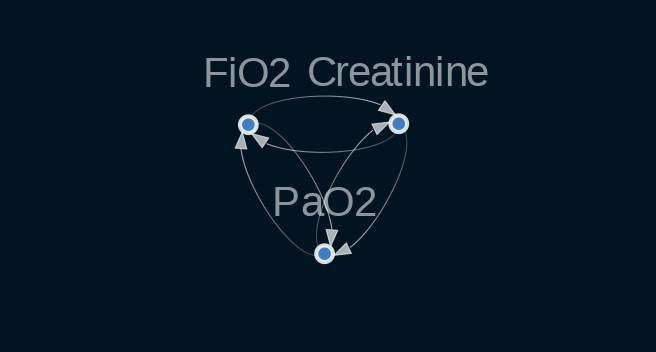

In [187]:
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
filename = "./structure_model.png"
viz.draw(filename)
Image(filename)

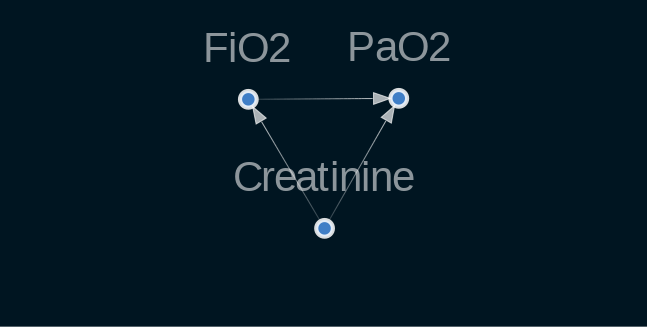

In [188]:
sm.remove_edges_below_threshold(0.8)
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
filename = "./structure_model.png"
viz.draw(filename)
Image(filename)

## Primary Analysis

We begin a more serious analysis by cleaning and normalising our data, imputing missing values as parameter means. Note we avoid discrete parameters with the exception of the target (ARDS) as NOTEARS favours continuous input.

In [0]:
df_prim = df[['BMI',	'RSC',	'PaO2/FiO2',	'PaCO2',	'Tidal_ml',\
'Plateau_Pressure_cmH2O', 'Total_PEEP_cmH2O',	'PaO2',	'FiO2',	'AGE',\
'HCO3',	'Creatinine', 'ARDS']]

In [0]:
 params = list(df_prim.columns)

In [0]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

df_prim = df_prim.replace([np.inf], np.nan)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
df_prim = imp.fit_transform(df_prim)

scaler = RobustScaler()
df_prim = scaler.fit_transform(df_prim)

df_prim = pd.DataFrame(df_prim, columns=params)

In [0]:
from causalnex.structure.notears import from_pandas
sm = from_pandas(df_prim)

As usual we apply thresholding.

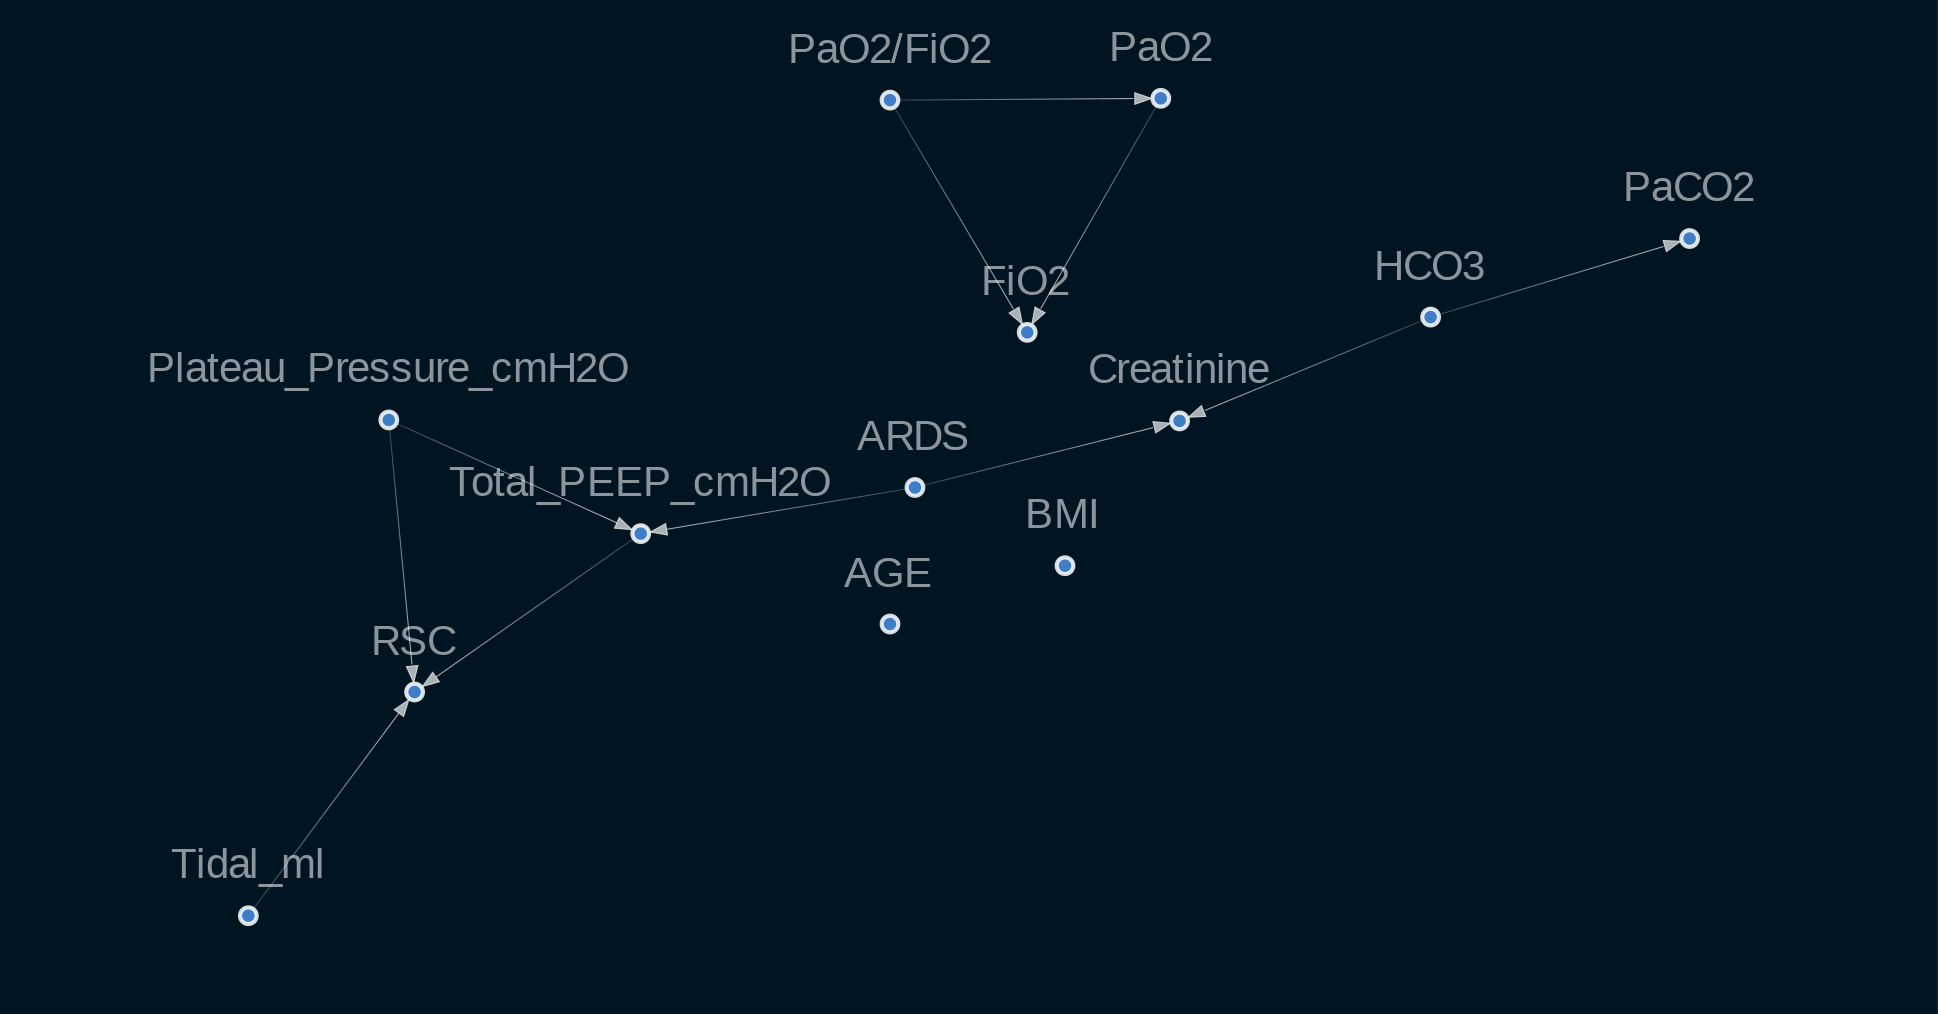

In [335]:
sm.remove_edges_below_threshold(0.3)
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.9"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
filename = "./structure_model.png"
viz.draw(filename)
Image(filename)

Given the two smaller graphs are not of interest to us, we remove them from view.

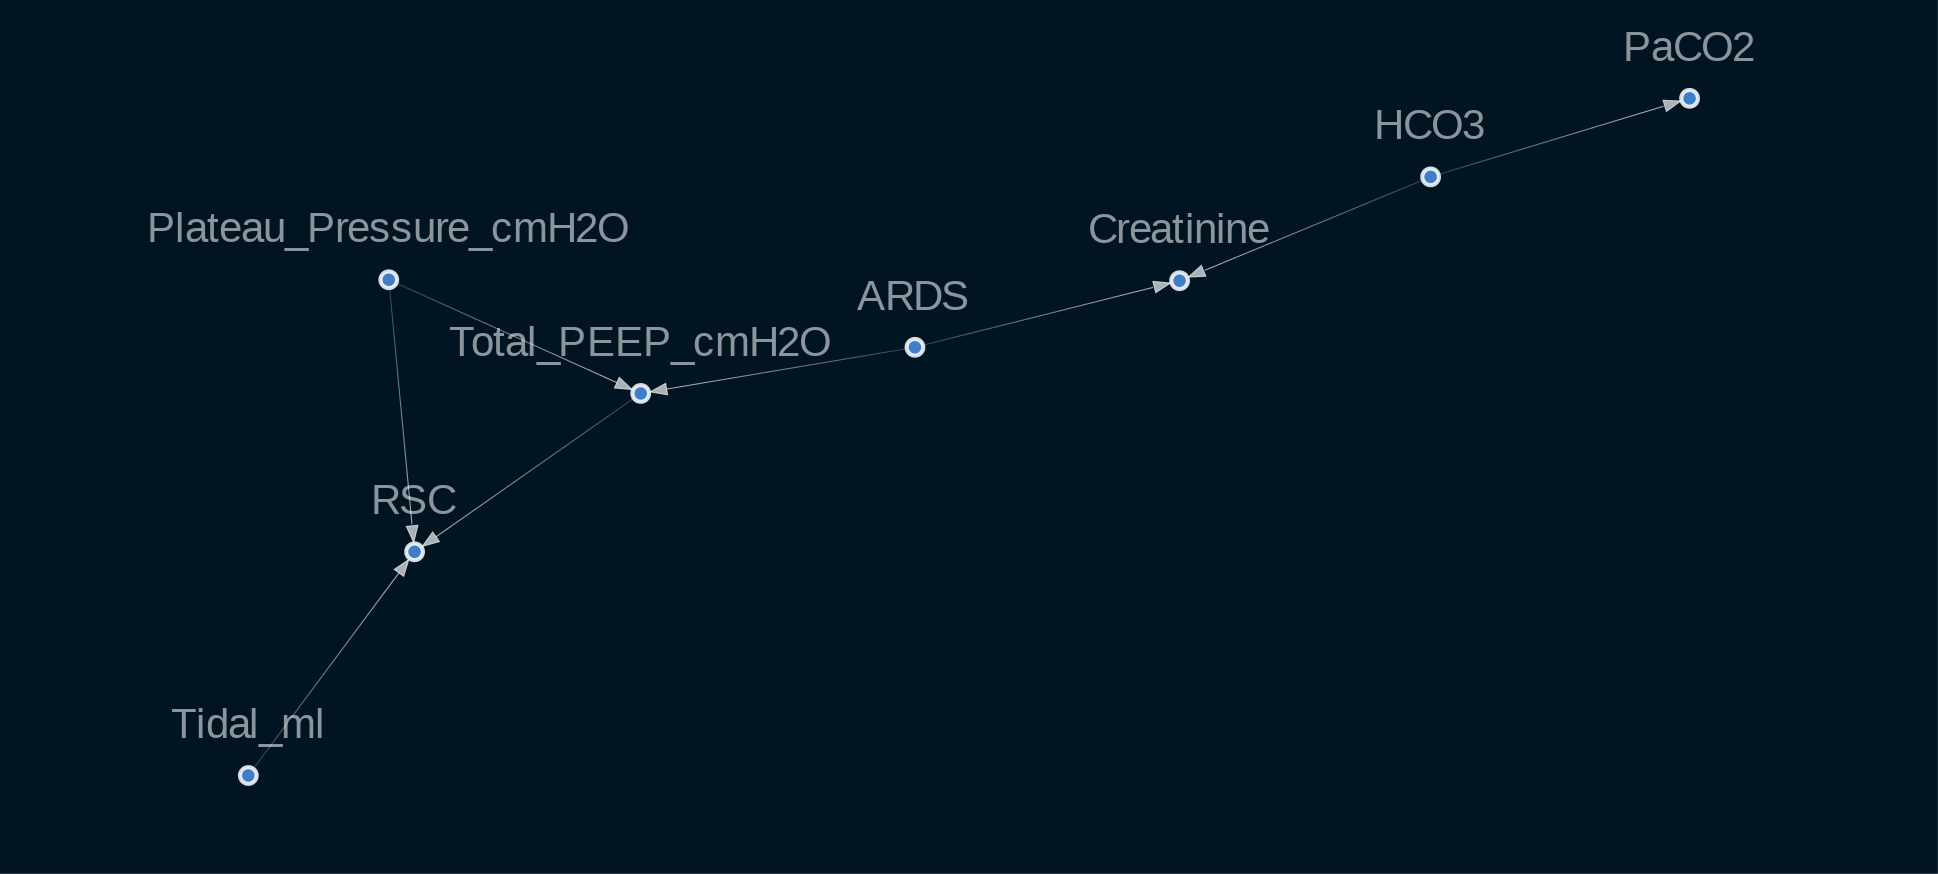

In [336]:
sm = sm.get_largest_subgraph()

viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.9"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
filename = "./structure_model.png"
viz.draw(filename)
Image(filename)

Next we discretise our data to generate a Bayesian network.